In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

import os
os.chdir('/content/gdrive/MyDrive/ViralMut/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import warnings

warnings.filterwarnings('ignore')

!mkdir -p ~/.fonts
!cp arial.ttf ~/.fonts/
!fc-cache -fv

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [3]:
from matplotlib import font_manager as fm

font_dir = os.path.join(os.environ['HOME'], '.fonts')
os.makedirs(font_dir, exist_ok=True)
font_name = 'arial.ttf'
font_path = os.path.join(font_dir, font_name)
fm.fontManager.addfont(font_path)

!cp {font_name} {font_dir}

## Load data

In [4]:
import pandas as pd

categories = ['pathogenic', 'benign', 'likely_pathogenic', 'likely_benign']

results = {}

for cat in categories:

    prot = pd.read_csv(f'./LLR/{cat}_LLR_results.csv').add_suffix('_prot')
    gene = pd.read_csv(f'./LLR/{cat}_LLR_CaLM_results.csv').add_suffix('_gene')

    merged = pd.concat([prot.reset_index(drop=True),
                        gene.reset_index(drop=True)], axis=1)

    meta_data = pd.read_csv(f'./data/{cat}_complete_with_AF.csv')

    merged['Chromosome'] = meta_data['Chromosome']
    merged['AF'] = meta_data['gnomAD_AF']

    results[cat] = merged


merged_pathogenic = results['pathogenic']
merged_benign = results['benign']
merged_likely_pathogenic = results['likely_pathogenic']
merged_likely_benign = results['likely_benign']

In [5]:
filtered_pathogenic = merged_pathogenic.dropna(subset=['LLR_prot', 'LLR_gene'])
filtered_benign = merged_benign.dropna(subset=['LLR_prot', 'LLR_gene'])
filtered_likely_pathogenic = merged_likely_pathogenic.dropna(subset=['LLR_prot', 'LLR_gene'])
filtered_likely_benign = merged_likely_benign.dropna(subset=['LLR_prot', 'LLR_gene'])

In [6]:
missense = pd.concat([
    filtered_pathogenic,
    filtered_likely_pathogenic,
    filtered_benign,
    filtered_likely_benign
])

missense['Diff'] = missense['LLR_prot'] - missense['LLR_gene']

## 4.8 Identification of missense variant with divergent model predictions

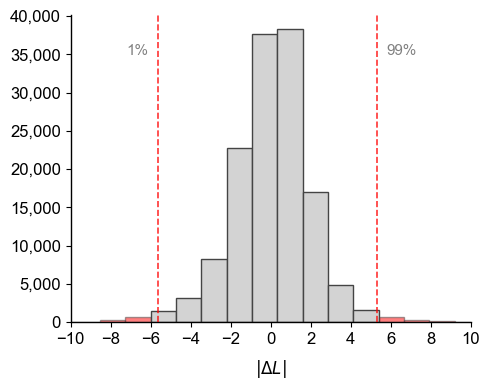

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

lower_cutoff = missense['Diff'].quantile(0.01)
upper_cutoff = missense['Diff'].quantile(0.99)

plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 9,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'axes.edgecolor': 'black',
    'axes.linewidth': 1
})

fig, ax = plt.subplots(figsize=(5, 4))

n, bins, patches = ax.hist(
    missense['Diff'],
    bins=20,
    color='#D3D3D3',
    edgecolor='#444444',
    linewidth=1,
    density=False,
    zorder=2
)


for patch, left_edge, right_edge in zip(patches, bins[:-1], bins[1:]):
    bin_center = (left_edge + right_edge) / 2

    if bin_center < lower_cutoff or bin_center > upper_cutoff:
        patch.set_facecolor('r')
        patch.set_alpha(0.5)

critical_kwargs = {
    'color': 'red',
    'linestyle': '--',
    'linewidth': 1.2,
    'alpha': 0.8,
    'zorder': 3
}
ax.axvline(lower_cutoff, **critical_kwargs)
ax.axvline(upper_cutoff, **critical_kwargs)

def add_percentile_label(ax, x_pos, label_text, offset_direction):

    offset = 0.5 * offset_direction

    ax.text(
        x_pos + offset,
        max(n) * 0.95,
        label_text,
        color='gray',
        fontsize=11,
        fontweight='bold',
        ha='right' if offset_direction < 0 else 'left',
        va='top',
        zorder=4
    )

add_percentile_label(ax, lower_cutoff, "1%", -1)
add_percentile_label(ax, upper_cutoff, "99%", 1)

ax.set_xlim(-10, 10)
ax.set_ylim(0, max(n) * 1.05)
ax.set_xlabel(r'$|\Delta L|$', labelpad=8)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: f'{int(x):,}' if x >= 1000 else str(int(x)))
)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

fig.tight_layout()
plt.show()

In [8]:
clm_pathogenic_better = missense[(missense['Diff'] > upper_cutoff) & (missense['Label_prot'].str.contains('pathogenic'))]
clm_benign_better = missense[(missense['Diff'] < lower_cutoff) & (missense['Label_prot'].str.contains('benign'))]
CLM_better = pd.concat([clm_pathogenic_better, clm_benign_better])

plm_pathogenic_better = missense[(missense['Diff'] < lower_cutoff) & (missense['Label_prot'].str.contains('pathogenic'))]
plm_benign_better = missense[(missense['Diff'] > upper_cutoff) & (missense['Label_prot'].str.contains('benign'))]
PLM_better = pd.concat([plm_pathogenic_better, plm_benign_better])

In [9]:
CLM_better

,Label_prot,Gene_prot,Site_prot,Ref_prot,Mut_prot,LLR_prot,Label_gene,Gene_gene,Site_gene,Ref_gene,Mut_gene,LLR_gene,Chromosome,AF,Diff
67,pathogenic,SDHAF2,78,G,R,-2.781353,pathogenic,SDHAF2,78,GGA,AGA,-9.720863,11,0.000000,6.939510
90,pathogenic,PAH,408,R,W,-5.131814,pathogenic,PAH,408,CGG,UGG,-11.179581,12,0.001943,6.047766
91,pathogenic,PAH,311,L,P,-4.434677,pathogenic,PAH,311,CUG,CCG,-13.437523,12,0.000032,9.002846
95,pathogenic,PAH,261,R,Q,-3.275591,pathogenic,PAH,261,CGA,CAA,-8.860537,12,0.000223,5.584946
101,pathogenic,PAH,413,R,P,-5.314795,pathogenic,PAH,413,CGC,CCC,-11.072532,12,0.000004,5.757736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64025,likely_benign,PTCHD3,486,A,V,-5.714899,likely_benign,PTCHD3,486,GCG,GUG,-0.062092,10,0.000008,-5.652807
65630,likely_benign,FLG,1286,L,W,-5.885525,likely_benign,FLG,1286,UUG,UGG,-0.231265,1,0.000032,-5.654260
65768,likely_benign,FGR,395,A,V,-2.131393,likely_benign,FGR,395,GCG,GUG,5.110479,1,0.000116,-7.241873
67388,likely_benign,SEC31B,288,R,W,1.817021,likely_benign,SEC31B,288,CGG,UGG,8.431937,10,0.000080,-6.614916


## 4.9 Characterization of amino acid substitution preferences

In [10]:
# Define Bias ratio
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests


missense['Pair'] = list(zip(missense["Ref_prot"], missense["Mut_prot"]))
CLM_better['Pair'] = list(zip(CLM_better["Ref_prot"], CLM_better["Mut_prot"]))
PLM_better['Pair'] = list(zip(PLM_better["Ref_prot"], PLM_better["Mut_prot"]))


overall_pair_counts = Counter(missense["Pair"])
clm_pair_counts = Counter(CLM_better["Pair"])
plm_pair_counts = Counter(PLM_better["Pair"])


total_overall_count = sum(overall_pair_counts.values())
total_clm_count = sum(clm_pair_counts.values())
total_plm_count = sum(plm_pair_counts.values())


all_pairs = set(overall_pair_counts.keys()).union(clm_pair_counts.keys(), plm_pair_counts.keys())
pair_df = pd.DataFrame({"Pair": list(all_pairs)})


pair_df["Count_overall"] = pair_df["Pair"].map(overall_pair_counts).fillna(0).astype(int)
pair_df["Count_clm"]     = pair_df["Pair"].map(clm_pair_counts).fillna(0).astype(int)
pair_df["Count_plm"]     = pair_df["Pair"].map(plm_pair_counts).fillna(0).astype(int)


pair_df["Freq_overall"] = pair_df["Count_overall"] / total_overall_count
pair_df["Freq_clm"]     = pair_df["Count_clm"] / total_clm_count
pair_df["Freq_plm"]     = pair_df["Count_plm"] / total_plm_count


pair_df["BR_clm"] = pair_df["Freq_clm"] / pair_df["Freq_overall"]
pair_df["BR_plm"] = pair_df["Freq_plm"] / pair_df["Freq_overall"]

In [11]:
# Assess the statistical significance of these enrichment patterns

# Subset vs Remainder
# Remainder = Overall - Subset

pvals_clm, pvals_plm = [], []


n_rest_clm_total = total_overall_count - total_clm_count
n_rest_plm_total = total_overall_count - total_plm_count

for i, row in pair_df.iterrows():

    n_sub_clm = row["Count_clm"]
    n_sub_plm = row["Count_plm"]
    n_total   = row["Count_overall"]


    a_clm = n_sub_clm
    b_clm = total_clm_count - n_sub_clm
    c_clm = n_total - n_sub_clm
    d_clm = n_rest_clm_total - c_clm

    contingency_clm = [[a_clm, b_clm], [c_clm, d_clm]]


    a_plm = n_sub_plm
    b_plm = total_plm_count - n_sub_plm
    c_plm = n_total - n_sub_plm
    d_plm = n_rest_plm_total - c_plm

    contingency_plm = [[a_plm, b_plm], [c_plm, d_plm]]


    _, pval_clm = fisher_exact(contingency_clm, alternative='two-sided')
    _, pval_plm = fisher_exact(contingency_plm, alternative='two-sided')

    pvals_clm.append(pval_clm)
    pvals_plm.append(pval_plm)


alpha = 0.01

reject_clm, pvals_clm_corr, _, _ = multipletests(pvals_clm, alpha=alpha, method='fdr_bh')
reject_plm, pvals_plm_corr, _, _ = multipletests(pvals_plm, alpha=alpha, method='fdr_bh')


pair_df["pvalue_clm_raw"]       = pvals_clm
pair_df["pvalue_clm_corrected"] = pvals_clm_corr
pair_df["significant_clm"]      = reject_clm

pair_df["pvalue_plm_raw"]       = pvals_plm
pair_df["pvalue_plm_corrected"] = pvals_plm_corr
pair_df["significant_plm"]      = reject_plm


clm_enriched = pair_df[(pair_df["significant_clm"]) & (pair_df["BR_clm"] > 1)].sort_values("BR_clm", ascending=False)
clm_depleted = pair_df[(pair_df["significant_clm"]) & (pair_df["BR_clm"] < 1)].sort_values("BR_clm", ascending=True)

plm_enriched = pair_df[(pair_df["significant_plm"]) & (pair_df["BR_plm"] > 1)].sort_values("BR_plm", ascending=False)
plm_depleted = pair_df[(pair_df["significant_plm"]) & (pair_df["BR_plm"] < 1)].sort_values("BR_plm", ascending=True)


print(f"Total Unique Pairs: {len(pair_df)}")
print(f"CLM Enriched: {len(clm_enriched)}, Depleted: {len(clm_depleted)}")
print(f"PLM Enriched: {len(plm_enriched)}, Depleted: {len(plm_depleted)}")

Total Unique Pairs: 150
CLM Enriched: 21, Depleted: 16
PLM Enriched: 29, Depleted: 20


In [12]:
codon_class = {
    'M': 1, 'W':1,
    'K': 2, 'N': 2, 'Y': 2, 'F': 2, 'C': 2, 'Q': 2, 'H': 2, 'E': 2, 'D': 2,
    'I': 3,
    'T': 4, 'P': 4, 'V': 4, 'A': 4, 'G': 4,
    'R': 6, 'S': 6, 'L': 6
}

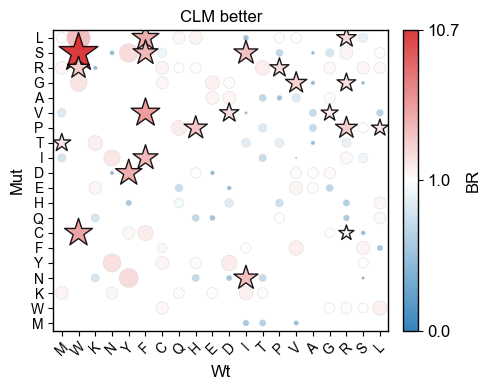

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np


pair_df[["Ref_prot", "Mut_prot"]] = pd.DataFrame(pair_df["Pair"].tolist(), index=pair_df.index)

pair_df["Ref_codon_class"] = pair_df["Ref_prot"].map(codon_class)
pair_df["Mut_codon_class"] = pair_df["Mut_prot"].map(codon_class)


df = pair_df.sort_values(by=["Ref_codon_class", "Mut_codon_class"])

amino_acids_sorted = sorted(codon_class.keys(), key=lambda x: codon_class[x])
aa_to_idx = {aa: idx for idx, aa in enumerate(amino_acids_sorted)}
df["Ref_prot_idx"] = df["Ref_prot"].map(aa_to_idx)
df["Mut_prot_idx"] = df["Mut_prot"].map(aa_to_idx)


max_val = max(abs(np.log2(df["BR_clm"].min())), abs(np.log2(df["BR_clm"].max())))
colors = ['#1f77b4', 'white', '#d62728']
cmap = mcolors.LinearSegmentedColormap.from_list("bwr", colors)
norm = mcolors.TwoSlopeNorm(vmin=df["BR_clm"].min(), vcenter=1, vmax=df["BR_clm"].max())

plt.figure(figsize=(5, 4))

# Group A: Significantly Enriched -> Represented by stars (highlighted).
# Group B: All other points (including non-significant and significantly depleted) -> Represented by circles (background)

df_enriched_sig = df[(df["significant_clm"]) & (df["BR_clm"] > 1)]
df_others = df[~df.index.isin(df_enriched_sig.index)]


plt.scatter(
    x=df_others["Ref_prot_idx"],
    y=df_others["Mut_prot_idx"],
    s=df_others["BR_clm"] * 50,
    c=df_others["BR_clm"],
    cmap=cmap,
    norm=norm,
    alpha=0.6,
    edgecolors="lightgray",
    linewidth=0.5,
    marker="o",
    label="Others"
)


scatter_sig = plt.scatter(
    x=df_enriched_sig["Ref_prot_idx"],
    y=df_enriched_sig["Mut_prot_idx"],
    s=df_enriched_sig["BR_clm"] * 80,
    c=df_enriched_sig["BR_clm"],
    cmap=cmap,
    norm=norm,
    alpha=0.9,
    edgecolors="black",
    marker="*",
    label="Sig. Enriched"
)


cbar = plt.colorbar(scatter_sig, fraction=0.046, pad=0.04)
cbar.set_label("BR", fontsize=12)
cbar.set_ticks([df["BR_clm"].min(), 1, df["BR_clm"].max()])
cbar.set_ticklabels([f"{df['BR_clm'].min():.1f}", "1.0", f"{df['BR_clm'].max():.1f}"])
cbar.outline.set_linewidth(1)

plt.xlabel("Wt", fontsize=12)
plt.ylabel("Mut", fontsize=12)
plt.title("CLM better", fontsize=12)

plt.xticks(
    ticks=range(len(amino_acids_sorted)),
    labels=amino_acids_sorted,
    rotation=45,
    fontsize=10
)
plt.yticks(
    ticks=range(len(amino_acids_sorted)),
    labels=amino_acids_sorted,
    fontsize=10
)

plt.xlim(-0.5, 19.5)
plt.ylim(-0.5, 19.5)


ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1)


plt.tight_layout()
plt.show()

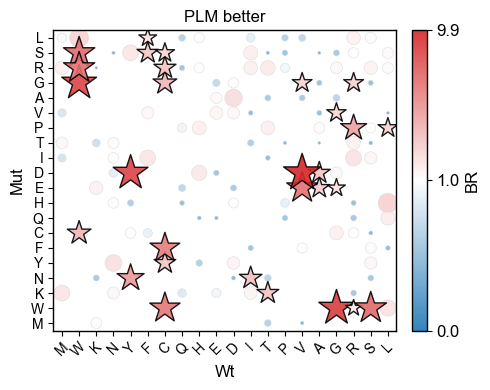

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np


pair_df[["Ref_prot", "Mut_prot"]] = pd.DataFrame(pair_df["Pair"].tolist(), index=pair_df.index)

pair_df["Ref_codon_class"] = pair_df["Ref_prot"].map(codon_class)
pair_df["Mut_codon_class"] = pair_df["Mut_prot"].map(codon_class)


df = pair_df.sort_values(by=["Ref_codon_class", "Mut_codon_class"])

amino_acids_sorted = sorted(codon_class.keys(), key=lambda x: codon_class[x])
aa_to_idx = {aa: idx for idx, aa in enumerate(amino_acids_sorted)}
df["Ref_prot_idx"] = df["Ref_prot"].map(aa_to_idx)
df["Mut_prot_idx"] = df["Mut_prot"].map(aa_to_idx)


max_val = max(abs(np.log2(df["BR_plm"].min())), abs(np.log2(df["BR_plm"].max())))
colors = ['#1f77b4', 'white', '#d62728']
cmap = mcolors.LinearSegmentedColormap.from_list("bwr", colors)
norm = mcolors.TwoSlopeNorm(vmin=df["BR_plm"].min(), vcenter=1, vmax=df["BR_plm"].max())

plt.figure(figsize=(5, 4))

df_enriched_sig = df[(df["significant_plm"]) & (df["BR_plm"] > 1)]
df_others = df[~df.index.isin(df_enriched_sig.index)]


plt.scatter(
    x=df_others["Ref_prot_idx"],
    y=df_others["Mut_prot_idx"],
    s=df_others["BR_plm"] * 50,
    c=df_others["BR_plm"],
    cmap=cmap,
    norm=norm,
    alpha=0.6,
    edgecolors="lightgray",
    linewidth=0.5,
    marker="o",
    label="Others"
)


scatter_sig = plt.scatter(
    x=df_enriched_sig["Ref_prot_idx"],
    y=df_enriched_sig["Mut_prot_idx"],
    s=df_enriched_sig["BR_plm"] * 80,
    c=df_enriched_sig["BR_plm"],
    cmap=cmap,
    norm=norm,
    alpha=0.9,
    edgecolors="black",
    marker="*",
    label="Sig. Enriched"
)


cbar = plt.colorbar(scatter_sig, fraction=0.046, pad=0.04)
cbar.set_label("BR", fontsize=12)
cbar.set_ticks([df["BR_plm"].min(), 1, df["BR_plm"].max()])
cbar.set_ticklabels([f"{df['BR_clm'].min():.1f}", "1.0", f"{df['BR_plm'].max():.1f}"])
cbar.outline.set_linewidth(1)

plt.xlabel("Wt", fontsize=12)
plt.ylabel("Mut", fontsize=12)
plt.title("PLM better", fontsize=12)

plt.xticks(
    ticks=range(len(amino_acids_sorted)),
    labels=amino_acids_sorted,
    rotation=45,
    fontsize=10
)
plt.yticks(
    ticks=range(len(amino_acids_sorted)),
    labels=amino_acids_sorted,
    fontsize=10
)

plt.xlim(-0.5, 19.5)
plt.ylim(-0.5, 19.5)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1)


plt.tight_layout()
plt.show()

## 4.10 Gene-level performance evaluation via bootstrapping

In [15]:
!pip install gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 8.9 MB/s eta 0:00:00


In [16]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import numpy as np

def calculate_gene_preference_auc(df, min_variants=25, min_minority_samples=5, max_imbalance_ratio=5):

    results = []

    gene_counts = df['Gene_prot'].value_counts()
    valid_genes = gene_counts[gene_counts >= min_variants].index
    filtered_df = df[df['Gene_prot'].isin(valid_genes)]

    pathogenic_labels = ['pathogenic', 'likely_pathogenic']
    benign_labels = ['benign', 'likely_benign']

    for gene, group in tqdm(filtered_df.groupby('Gene_prot')):

        try:

            y_binary = group['Label_prot'].map(lambda x: 1 if x in pathogenic_labels else (0 if x in benign_labels else None))
            y_binary = y_binary.dropna()

            if len(y_binary) < min_variants:
                continue

            n_pathogenic = (y_binary == 1).sum()
            n_benign = (y_binary == 0).sum()
            minority_count = min(n_pathogenic, n_benign)
            majority_count = max(n_pathogenic, n_benign)

            if minority_count < min_minority_samples:
                continue

            current_ratio = majority_count / (minority_count if minority_count > 0 else 1)

            if current_ratio > max_imbalance_ratio:
                continue


            calm_scores = -group.loc[y_binary.index, 'LLR_gene'].values
            esm_scores = -group.loc[y_binary.index, 'LLR_prot'].values

            auc_calm = roc_auc_score(y_binary, calm_scores)
            auc_esm = roc_auc_score(y_binary, esm_scores)

            results.append({
                'Gene': gene,
                'N_variants': len(y_binary),
                'N_Pathogenic': n_pathogenic,
                'N_Benign': n_benign,
                'Imbalance_ratio': round(current_ratio, 2),
                'AUC_CaLM': auc_calm,
                'AUC_ESM': auc_esm,
                'Preference': auc_esm - auc_calm
            })

        except Exception as e:

            continue

    return pd.DataFrame(results)

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from tqdm import tqdm

def calculate_gene_preference_auc_with_bootstrap(
    df,
    min_variants=20,
    min_minority_samples=5,
    max_imbalance_ratio=5,
    n_bootstraps=1000,
    ci_alpha=0.95,
    random_seed=26
):

    rng = np.random.RandomState(random_seed)

    results = []

    gene_counts = df['Gene_prot'].value_counts()
    valid_genes = gene_counts[gene_counts >= min_variants].index

    valid_genes = sorted(list(valid_genes))

    filtered_df = df[df['Gene_prot'].isin(valid_genes)]

    pathogenic_labels = ['pathogenic', 'likely_pathogenic']
    benign_labels = ['benign', 'likely_benign']

    for gene, group in tqdm(filtered_df.groupby('Gene_prot'), desc="Analyzing Genes"):

        if gene not in valid_genes:
            continue

        try:
            y_binary = group['Label_prot'].map(
                lambda x: 1 if x in pathogenic_labels else (0 if x in benign_labels else None)
            ).dropna()

            if len(y_binary) < min_variants: continue

            n_pathogenic = (y_binary == 1).sum()
            n_benign = (y_binary == 0).sum()

            if n_pathogenic == 0 or n_benign == 0: continue

            minority_count = min(n_pathogenic, n_benign)
            majority_count = max(n_pathogenic, n_benign)

            if minority_count < min_minority_samples: continue

            current_ratio = majority_count / minority_count
            if current_ratio > max_imbalance_ratio: continue

            current_indices = y_binary.index
            y_true = y_binary.values
            calm_scores = -group.loc[current_indices, 'LLR_gene'].values
            esm_scores = -group.loc[current_indices, 'LLR_prot'].values

            auc_calm_orig = roc_auc_score(y_true, calm_scores)
            auc_esm_orig = roc_auc_score(y_true, esm_scores)
            delta_orig = auc_esm_orig - auc_calm_orig

            boot_diffs = []

            for _ in range(n_bootstraps):
                indices_boot = resample(
                    range(len(y_true)),
                    replace=True,
                    stratify=y_true,
                    random_state=rng
                )

                y_boot = y_true[indices_boot]

                if len(np.unique(y_boot)) < 2:
                    continue

                calm_boot = calm_scores[indices_boot]
                esm_boot = esm_scores[indices_boot]

                score_c = roc_auc_score(y_boot, calm_boot)
                score_p = roc_auc_score(y_boot, esm_boot)
                boot_diffs.append(score_p - score_c)

            if len(boot_diffs) < (n_bootstraps * 0.9):
                continue

            alpha_lower = (1.0 - ci_alpha) / 2.0 * 100
            alpha_upper = (1.0 + ci_alpha) / 2.0 * 100

            ci_lower = np.percentile(boot_diffs, alpha_lower)
            ci_upper = np.percentile(boot_diffs, alpha_upper)

            is_significant = (ci_lower > 0) or (ci_upper < 0)

            results.append({
                'Gene': gene,
                'N_variants': len(y_binary),
                'N_Pathogenic': n_pathogenic,
                'N_Benign': n_benign,
                'Imbalance_ratio': round(current_ratio, 2),
                'AUC_CaLM': auc_calm_orig,
                'AUC_ESM': auc_esm_orig,
                'Delta_ROC': delta_orig,
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper,
                'Significant': is_significant
            })

        except Exception as e:
            continue

    return pd.DataFrame(results)

In [18]:
gene_preference_df = calculate_gene_preference_auc_with_bootstrap(missense, min_variants=20)

Analyzing Genes: 100%|██████████| 1249/1249 [13:41<00:00,  1.52it/s]


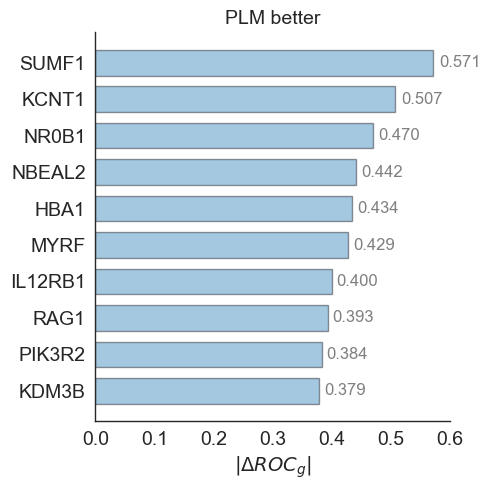

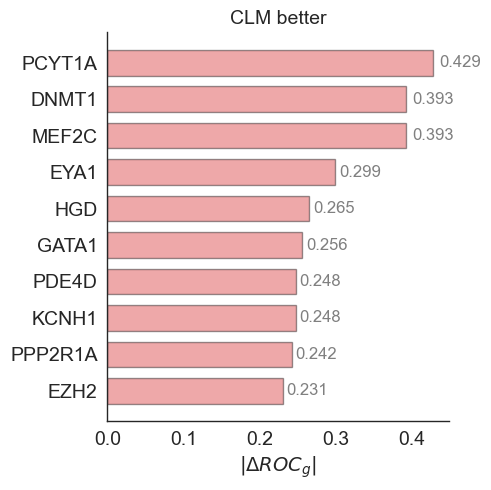

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

significant_df = gene_preference_df[gene_preference_df['Significant'] == True].copy()

plm_top10 = significant_df.nlargest(10, 'Delta_ROC').copy()
plm_top10 = plm_top10.sort_values('Delta_ROC', ascending=True)


clm_top10 = significant_df.nsmallest(10, 'Delta_ROC').copy()
clm_top10 = clm_top10.sort_values('Delta_ROC', ascending=False)
clm_top10['Abs_Delta_ROC'] = clm_top10['Delta_ROC'].abs()



def plot_top_genes(data, value_col, label_col, title, color):

    plt.figure(figsize=(5, 5))

    bars = plt.barh(data['Gene'], data[value_col], color=color, edgecolor='black', height=0.7, alpha = 0.4)

    plt.title(title, fontsize=14)

    plt.xlabel(r'$|\Delta ROC_g|$', fontsize=14)

    plt.ylabel(None)
    sns.despine()

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    for bar, original_val in zip(bars, data[label_col]):

        width = bar.get_width()

        plt.text(width * 1.02,
                 bar.get_y() + bar.get_height()/2,
                 f'{abs(original_val):.3f}',
                 va='center', fontsize=12, color='gray')

    plt.tight_layout()



plot_top_genes(
    data=plm_top10,
    value_col='Delta_ROC',
    label_col='Delta_ROC',
    title='PLM better',
    color='#1f77b4'
)


plot_top_genes(
    data=clm_top10,
    value_col='Abs_Delta_ROC',
    label_col='Abs_Delta_ROC',
    title='CLM better',
    color='#d62728'
)

plt.show()

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gseapy as gp
import textwrap
import re

def plot_scatter_comparison(df_pref):

    plt.figure(figsize=(5, 5))

    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 14,
        'axes.labelsize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial'],
        'axes.edgecolor': 'black',
        'axes.linewidth': 1.5
    })


    plt.scatter(df_pref['AUC_ESM'],
                df_pref['AUC_CaLM'],
                c='lightgrey',
                alpha=0.5,
                s=15)

    threshold = 0.05

    calm_wins = df_pref[
    (df_pref['Delta_ROC'] < -threshold) &
    (df_pref['CI_Upper'] < 0)]

    print(calm_wins['Gene'].to_list())

    esm_wins = df_pref[
    (df_pref['Delta_ROC'] > threshold) &
    (df_pref['CI_Lower'] > 0)]

    print(esm_wins['Gene'].to_list())

    plt.scatter(calm_wins['AUC_ESM'],
                calm_wins['AUC_CaLM'],
                c='#d62728', alpha=0.5, s=25, label=f'CLM better ({len(calm_wins)})')

    plt.scatter(esm_wins['AUC_ESM'],
                esm_wins['AUC_CaLM'],
                c='#1f77b4', alpha=0.5, s=25, label=f'PLM better ({len(esm_wins)})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)

    plt.xlabel('ESM-2')
    plt.ylabel('CaLM')


    plt.legend(loc='upper center',
               bbox_to_anchor=(0.5, -0.15),
              frameon=False,
              ncol=2)

    plt.show()

    return calm_wins, esm_wins

['ABCD1', 'AFG3L2', 'AR', 'ARX', 'ATP1A1', 'CACNA1A', 'CACNA1C', 'DHX37', 'DNM1', 'DNMT1', 'EYA1', 'EZH2', 'FOXG1', 'FOXP3', 'GARS1', 'GATA1', 'GATA2', 'GJA3', 'GNB1', 'HGD', 'KCNH1', 'MEF2C', 'PCYT1A', 'PDE4D', 'PPP2R1A', 'SCN3A', 'SNRNP200', 'SOX9', 'TGFBR1']
['ACAD9', 'CACNA1D', 'CAMTA1', 'CC2D2A', 'CD40LG', 'CFH', 'CPLANE1', 'CYBB', 'DEAF1', 'DICER1', 'DOK7', 'DYNC1H1', 'DYNC2H1', 'EXT1', 'EYS', 'GNPTAB', 'GRIN2A', 'GRIN2B', 'HBA1', 'HEXB', 'HLCS', 'IL12RB1', 'IL2RG', 'INF2', 'ITGB4', 'KCNJ11', 'KCNT1', 'KDM3B', 'KDM6A', 'MAN2B1', 'MECP2', 'MORC2', 'MSH6', 'MYO15A', 'MYOC', 'MYRF', 'NBEAL2', 'NEU1', 'NR0B1', 'NSD2', 'NTRK1', 'OCA2', 'OFD1', 'OTOF', 'PC', 'PIK3R2', 'PKD1', 'POGZ', 'PURA', 'RAG1', 'RB1', 'SERPING1', 'SLC16A2', 'SLC4A11', 'SMC1A', 'SUMF1', 'TAF1', 'TECTA', 'TGM1', 'TNFRSF1A', 'TP53', 'TYMP', 'USH2A', 'WAS', 'WDR62', 'WFS1']


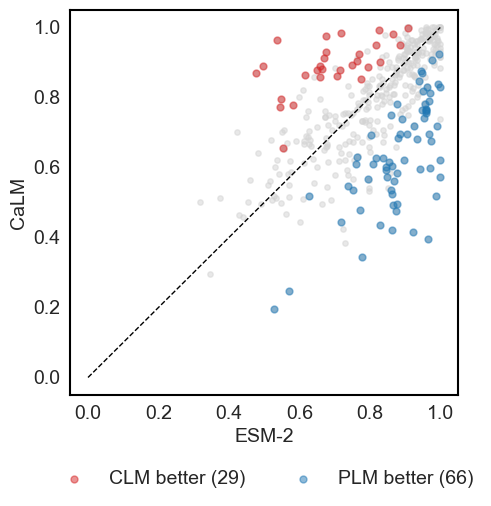

In [21]:
calm_specific_genes, esm_specific_genes = plot_scatter_comparison(gene_preference_df)

## 4.11 Gene-level constraint analysis

CaLM Group (n=28): Mean pLI = 0.789 +/- 0.072
ESM Group  (n=64): Mean pLI = 0.451 +/- 0.061
p-value: 7.22e-03
Significant


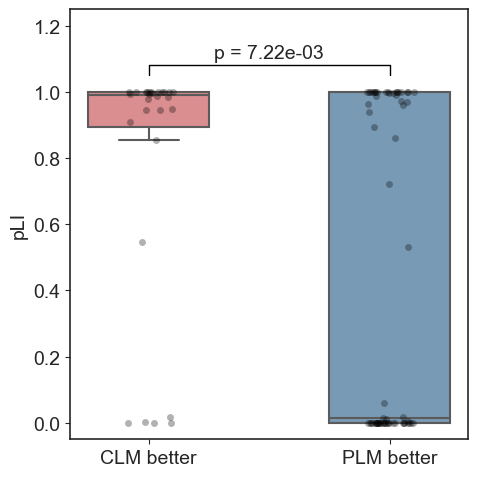

In [22]:
import pandas as pd
import requests
import gzip
import io
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, sem



url = "https://storage.googleapis.com/gcp-public-data--gnomad/release/2.1.1/constraint/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz"

try:
    response = requests.get(url)
    with gzip.open(io.BytesIO(response.content), 'rt') as f:
        df_gnomad = pd.read_csv(f, sep='\t')

    pli_dict = df_gnomad.set_index('gene')['pLI'].to_dict()

    data = []

    found_calm = 0
    for g in calm_specific_genes['Gene']:
        if g in pli_dict:
            data.append({'Gene': g, 'Group': 'CLM better', 'pLI': pli_dict[g]})
            found_calm += 1

    found_esm = 0
    for g in esm_specific_genes['Gene']:
        if g in pli_dict:
            data.append({'Gene': g, 'Group': 'PLM better', 'pLI': pli_dict[g]})
            found_esm += 1

    df_plot = pd.DataFrame(data)


    group_calm = df_plot[df_plot['Group'] == 'CLM better']['pLI']
    group_esm = df_plot[df_plot['Group'] == 'PLM better']['pLI']

    # Mann-Whitney U Test
    stat, p_val = mannwhitneyu(group_calm, group_esm, alternative='two-sided')

    print(f"CaLM Group (n={found_calm}): Mean pLI = {group_calm.mean():.3f} +/- {sem(group_calm):.3f}")
    print(f"ESM Group  (n={found_esm}): Mean pLI = {group_esm.mean():.3f} +/- {sem(group_esm):.3f}")
    print(f"p-value: {p_val:.2e}")

    if p_val < 0.05:
        print("Significant")
    else:
        print("Not Significant")

    plt.figure(figsize=(5, 5))
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 15,
        'axes.labelsize': 14,
        'xtick.labelsize': 13,
        'ytick.labelsize': 13,
        'legend.fontsize': 13,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial'],
        'axes.edgecolor': 'black',
        'axes.linewidth': 1.2
        })

    sns.set_style("ticks")
    my_pal = {'CLM better': '#E68284', 'PLM better': '#6F9BBF'}

    ax = sns.boxplot(x='Group', y='pLI', data=df_plot, palette=my_pal,
                     width=0.5, linewidth=1.5, fliersize=0)

    sns.stripplot(x='Group', y='pLI', data=df_plot, color='black', alpha=0.3, jitter=True, size=5)

    y_max = 1.15
    y_line = 1.05
    col_max = df_plot['pLI'].max()

    plt.plot([0, 0, 1, 1], [y_line, y_line+0.03, y_line+0.03, y_line], lw=1.0, c='k')
    plt.text(0.5, y_line+0.04, f"p = {p_val:.2e}", ha='center', va='bottom', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)

    plt.ylabel('pLI', fontsize=14)
    plt.xlabel('', fontsize=14)
    plt.ylim(-0.05, 1.25)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")